In [1]:
import sys
import inspect
from importlib import reload

import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from scipy.constants import pi, c, epsilon_0, mu_0

import quvac
from quvac.paraxial_gaussian import ParaxialGaussianAnalytic
from quvac.field import ExternalField
from quvac.vacuum_emission import VacuumEmission

In [39]:
def kmax_grid(laser_params):
    '''
    Laser params must include lam, tau, w0, theta and phi
    theta, phi in degrees
    '''
    lam, tau = laser_params['lmbd'], laser_params['tau']
    theta, phi = laser_params['theta'], laser_params['phi']
    if 'w0' in laser_params.keys():
        w0 = laser_params['w0']

    k = 2*np.pi/lam    
    theta /= 180/np.pi
    phi /= 180/np.pi
    
    ekx = np.sin(theta) * np.cos(phi)
    eky = np.sin(theta) * np.sin(phi)
    ekz = np.cos(theta)
    ek = np.array([ekx, eky, ekz])

    if np.sin(theta) == 0.0:
        phi = 0.0
    
    e1x = -np.sin(phi)
    e1y = np.cos(phi)
    e1z = 0.0
    e1 = np.array([e1x, e1y, e1z])

    e2x = np.cos(phi) * np.cos(theta)
    e2y = np.sin(phi) * np.cos(theta)
    e2z = -np.sin(theta)
    e2 = np.array([e2x, e2y, e2z])
        
    kbw_perp = 4/w0
    kbw_long = 8/(c*tau)
    
    k0 = ek * k
    kmax = np.abs(k0 + ek * kbw_long)
    
    for beta in np.linspace(0, 2*np.pi, 64, endpoint=False):
        kp = k0 + ek * kbw_long + kbw_perp * (np.sin(beta) * e1 + np.cos(beta) * e2)
        kmax = np.maximum(kmax, np.abs(kp))
    
    return kmax

def get_spatial_steps(lasers, L, grid_res=1, equal_resolution=False):
    '''
    Calculates necessary spatial resolution
    
    grid_res: [float] - controls the resolution
    '''
    kmax = np.zeros((3,))
    for laser_params in lasers:
        kmax = np.maximum(kmax, kmax_grid(laser_params))
    
    # test cigar conjecture
    if equal_resolution:
        kmax = np.max(kmax) * np.ones(3) 
    N = np.ceil(grid_res * L * 3 * kmax/np.pi).astype(int)
    # N = [pp.helper.fftw_padsize(n) for n in N]
    return N

def get_t_steps(t_start, t_end, lam, grid_res=1):
    '''
    Calculates necessary temporal resolution
    
    grid_res: [float] - controls the resolution
    '''
    fmax = c/lam
    return int(np.ceil((t_end-t_start)*fmax*6*grid_res))

In [43]:
def W_to_E0(W, tau, w0):
    return 2*(8/np.pi)**0.25*np.sqrt(W/(tau*w0**2*np.pi))


tau = 20e-15
W = 25
lam = 1e-6
w0 = 1*lam

E0 = W_to_E0(W, tau, w0)

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lmbd": lam,
    "w0": w0,
    "tau": tau,
    # "E0": E0,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 180,
    "phi": 0,
    "beta": 90,
    "lmbd": lam,
    "w0": w0,
    "tau": tau,
    # "E0": E0,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0 = 4*w0
x = np.linspace(-x0,x0,32).reshape((-1,1,1))
y0 = 4*w0
y = np.linspace(-y0,y0,32).reshape((1,-1,1))
z0 = 10*w0
z = np.linspace(-z0,z0,256).reshape((1,1,-1))
grid = (x, y, z)

field1 = ParaxialGaussianAnalytic(field_1, grid)
field = ExternalField(fields_params, grid)

In [41]:
get_t_steps(-2*tau, 2*tau, 0.8e-6)

180

In [42]:
get_spatial_steps(fields_params, np.array([4*w0, 4*w0, 10*w0]))

array([16, 16, 73])

In [20]:
print(tau*c)
print(np.pi*lam)

5.99584916e-06
3.141592653589793e-06


In [44]:
N = np.prod(field.fields[0].grid_shape)

In [50]:
vacem = VacuumEmission(field)

1.811562331173633e+17
262144
5.223317214502852e-21


In [51]:
t_grid = np.linspace(-2*tau, 2*tau, 361)
vacem.calculate_vacuum_current(t_grid)

In [52]:
Ntot = vacem.calculate_total_signal()
print(Ntot)

2115808.419367646


In [53]:
print(Ntot)

2115808.419367646


In [48]:
Ntot / (np.pi*np.sqrt(4*np.pi))

np.float64(3383.2067257629637)

In [49]:
1.46e-2 * W**3 * (1e-6/lam)**5

228.125

101 101 401


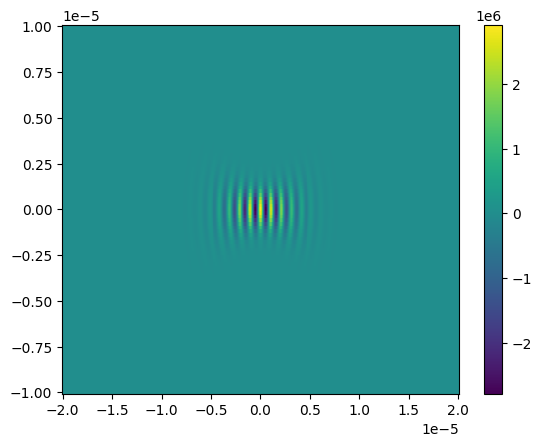

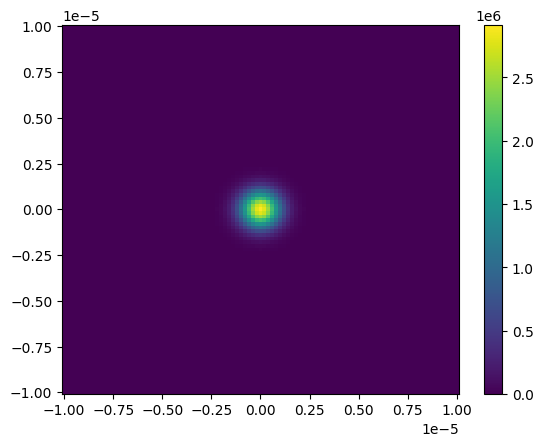

In [20]:
x_, y_, z_ = x.flatten(), y.flatten(), z.flatten()
nx, ny, nz = len(x_), len(y_), len(z_)
print(nx, ny, nz)

plt.figure()
plt.pcolormesh(z_, x_, Ex[:,ny//2,:])
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(y_, x_, Ex[:,:,nz//2])
plt.colorbar()
plt.show()

In [14]:
E0 = 2 * (8/np.pi)**0.25 * np.sqrt(W/(tau*w0**2*np.pi))
E0

np.float64(11268862935916.912)

In [5]:
t = 25e-15
Ex = field.calculate_field(t)

In [6]:
nx, ny, nz = x.size, y.size, z.size

plt.figure()
plt.pcolormesh(x.ravel(), y.ravel(), Ex[:,:,nz//2].T)
plt.colorbar()
plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 640x480 with 0 Axes>

In [19]:
members = dict(inspect.getmembers(field, lambda a:not(inspect.isroutine(a))))
for name,val in members.items():
    print(f"{name}: {sys.getsizeof(val)}")

# names = [name for name in dir(field)
#          if not name.startswith("__") and not inspect.isroutine(field.__dict__[name])]
# print(names)
# for name in names:
#     print(f"{name}: {sys.getsizeof(field.__dir__[name])}")

B0: 24
E: 29428312
E0: 24
R: 29428312
__class__: 1704
__dict__: 1584
__doc__: 722
__module__: 64
__weakref__: 16
beta: 24
focus_t: 24
focus_x: 64
grid: 64
grid_shape: 88
k: 24
lmbd: 24
omega: 24
phase0: 24
phase_no_t: 29428312
phi: 24
r2: 29428312
rotation: 232
rotation_bwd: 232
rotation_bwd_m: 128
rotation_m: 128
t0: 24
tau: 24
theta: 24
w: 29428312
w0: 24
x: 29428312
x0: 24
x_: 144
y: 29428312
y0: 24
y_: 144
z: 29428312
z0: 24
zR: 24
z_: 144


In [20]:
144**3

2985984

In [8]:
x = np.ones(10000)*2
y = np.ones(10000)*3

c = []
for i in range(2):
    val = ne.evaluate("i*x + y")
    c.append(val)

In [9]:
print(c)

[array([3., 3., 3., ..., 3., 3., 3.]), array([5., 5., 5., ..., 5., 5., 5.])]


In [10]:
for el in c:
    print(sys.getsizeof(el))

80112
80112


In [9]:
a = np.ones(100)*2
b = np.ones(100)*3

for i in range(2):
    d = ne.evaluate('a+b', local_dict={'a': np.zeros(100)})
    print(d)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]


In [6]:
np.savez(fn, b=b)

In [7]:
data = np.load(fn)
list(data.keys())

['b']

In [6]:
a = np.ones(100)*10
b = np.ones(100)
c = 'a + b'
ex = f'{c} + 1'
ne.evaluate(ex)

array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12.])